In [2]:
original = "vocal_sample.wav"
transferred = "output/transfer/vocal_sample/24_08_2025_14_17_53_waterfall_0.wav"


In [3]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import torch
import torchaudio
import torch.nn.functional as F
from audioldm.clap.encoders import CLAPAudioEmbeddingClassifierFreev2
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy import signal

# import seaborn as sns  # Commented out since it's not used

# Set matplotlib style for dark background and scientific fonts
plt.style.use('dark_background')
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Computer Modern', 'Times New Roman', 'DejaVu Serif'],
    'font.size': 11,
    'axes.titlesize': 12,
    'axes.labelsize': 11,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.titlesize': 14,
    'text.usetex': False,  # Set to True if you have LaTeX installed
    'axes.grid': True,
    'grid.alpha': 0.3,
    'grid.color': '#404040',
    'axes.facecolor': '#1a1a1a',
    'figure.facecolor': '#0d1117',
    'axes.edgecolor': '#666666',
    'text.color': 'white',
    'axes.labelcolor': 'white',
    'xtick.color': 'white',
    'ytick.color': 'white'
})

# Load audio files
def load_audio(file_path, sr=16000):
    try:
        y, _ = librosa.load(file_path, sr=sr)
        return y
    except FileNotFoundError:
        print(f"File not found: {file_path}")
        return None
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None

# Load both audio files
print("Loading audio files...")
audio_orig = load_audio(original)
audio_trans = load_audio(transferred)

if audio_orig is None or audio_trans is None:
    print("Could not load one or both audio files. Please check the file paths.")
    exit()

print(f"Original audio shape: {audio_orig.shape}")
print(f"Transferred audio shape: {audio_trans.shape}")

# Make audio files the same length for proper comparison
def match_audio_lengths(audio1, audio2):
    """Make two audio arrays the same length by padding or trimming"""
    len1, len2 = len(audio1), len(audio2)
    
    if len1 == len2:
        return audio1, audio2
    
    # Use the shorter length to trim both
    min_len = min(len1, len2)
    audio1_matched = audio1[:min_len]
    audio2_matched = audio2[:min_len]
    
    print(f"🔧 Matched audio lengths to {min_len} samples ({min_len/16000:.2f}s)")
    return audio1_matched, audio2_matched

# Match the lengths
audio_orig, audio_trans = match_audio_lengths(audio_orig, audio_trans)

print(f"Matched Original audio shape: {audio_orig.shape}")
print(f"Matched Transferred audio shape: {audio_trans.shape}")



Loading audio files...
Original audio shape: (80000,)
Transferred audio shape: (120992,)
🔧 Matched audio lengths to 80000 samples (5.00s)
Matched Original audio shape: (80000,)
Matched Transferred audio shape: (80000,)
Original audio shape: (80000,)
Transferred audio shape: (120992,)
🔧 Matched audio lengths to 80000 samples (5.00s)
Matched Original audio shape: (80000,)
Matched Transferred audio shape: (80000,)


Thesimilarity of the Contrastive Embeddings

In [4]:
from audioldm.pipeline import build_model  # your pipeline.py

# -------- Example --------
if __name__ == "__main__":
    device = "cuda" if torch.cuda.is_available() else "cpu"
    latent_diffusion = build_model(model_name="audioldm-m-full")  # loads ckpt + config

Load AudioLDM: %s audioldm-m-full
DiffusionWrapper has 415.95 M params.
DiffusionWrapper has 415.95 M params.


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel wer

In [5]:
import torch
import torchaudio
from einops import repeat
from audioldm.audio.stft import TacotronSTFT
from audioldm.audio.tools import get_mel_from_wav
from audioldm.audio.tools import wav_to_fbank
from audioldm.variational_autoencoder.distributions import DiagonalGaussianDistribution


# -------- Preprocessing --------
def preprocess_audio(path, device="cuda"):
    wav, sr = torchaudio.load(path)
    wav = torchaudio.functional.resample(wav, sr, 16000).mean(0).unsqueeze(0)  # mono [1,T]

    stft = TacotronSTFT(
        filter_length=1024,
        hop_length=160,
        win_length=1024,
        n_mel_channels=64,
        sampling_rate=16000,
        mel_fmin=0,
        mel_fmax=8000,
    )
    mel, _, _ = get_mel_from_wav(wav.squeeze(), stft)  # [n_mels, T]
    mel = torch.tensor(mel).unsqueeze(0).unsqueeze(0).to(device)     # [1,1,n_mels,T]
    return mel

# -------- Encode into latent --------
def get_latent(mel, latent_diffusion):
    mel = repeat(mel, "1 ... -> b ...", b=1)
    enc = latent_diffusion.first_stage_model.encode(mel)
    
    # if it's a distribution, sample
    if isinstance(enc, DiagonalGaussianDistribution):
        z = enc.sample()
    else:
        z = enc
    
    return latent_diffusion.scale_factor * z


# -------- Normalized L2 distance --------
def latent_dist(path1, path2, latent_diffusion, device="cuda"):
    duration=5
    fn_STFT = TacotronSTFT(
        filter_length=1024,
        hop_length=160,
        win_length=1024,
        n_mel_channels=64,
        sampling_rate=16000,
        mel_fmin=0,
        mel_fmax=8000,
    )
    mel1, _, _ = wav_to_fbank(
        path1, target_length=int(duration * 102.4), fn_STFT=fn_STFT
    )
    mel2, _, _ = wav_to_fbank(
        path2, target_length=int(duration * 102.4), fn_STFT=fn_STFT
    )
    mel1 = mel1.unsqueeze(0).unsqueeze(0).to(device)
    mel1 = repeat(mel1, "1 ... -> b ...", b=1)
    mel2 = mel2.unsqueeze(0).unsqueeze(0).to(device)
    mel2 = repeat(mel2, "1 ... -> b ...", b=1)
    z1 = get_latent(mel1, latent_diffusion)
    z2 = get_latent(mel2, latent_diffusion)

    # match lengths
    T = min(z1.shape[-1], z2.shape[-1])
    z1, z2 = z1[..., :T], z2[..., :T]

    # element-wise normalized L2
    l2_norm = torch.norm(z1 - z2, p=2) / z1.numel()

    # cosine similarity
    cos_sim = torch.nn.functional.cosine_similarity(z1.flatten(), z2.flatten(), dim=0)

    return l2_norm.item(), cos_sim.item()


This shows the difference in similarity between the latent codes of the vocal sample (against itself) and with the style transfered vocal sample



In [6]:
dist, sim, = latent_dist("vocal_sample.wav", "vocal_sample.wav", latent_diffusion, device)
print("L2 distance vocal to vocal:", dist, "cos similarity:", sim)
dist, sim = latent_dist("vocal_sample.wav", "output/transfer/vocal_sample/24_08_2025_14_17_53_waterfall_0.wav", latent_diffusion, device)
print("L2 distance vocal to trans:", dist, "cos similarity:", sim)


L2 distance vocal to vocal: 0.001658322406001389 cos similarity: 0.9842782020568848
L2 distance vocal to trans: 0.009464367292821407 cos similarity: 0.4188123345375061
L2 distance vocal to trans: 0.009464367292821407 cos similarity: 0.4188123345375061


Step 1: Loss = 154.765427
Step 2: Loss = 153.032730
Step 3: Loss = 151.798019
Step 4: Loss = 151.153748
Step 5: Loss = 149.613571
Step 6: Loss = 149.164352
Step 7: Loss = 148.048325
Step 8: Loss = 146.999146
Step 9: Loss = 146.547195
Step 10: Loss = 146.103653
Step 11: Loss = 145.194458
Step 12: Loss = 144.562256
Step 13: Loss = 144.097870
Step 14: Loss = 144.114777
Step 15: Loss = 143.486694
Step 16: Loss = 142.740387
Step 17: Loss = 142.360291
Step 18: Loss = 141.453186
Step 19: Loss = 141.001266
Step 20: Loss = 140.451675
Step 21: Loss = 140.416321
Step 22: Loss = 139.954773
Step 23: Loss = 139.543381
Step 24: Loss = 139.397705
Step 25: Loss = 138.489609
Step 26: Loss = 138.138123
Step 27: Loss = 137.834702
Step 28: Loss = 137.291565
Step 29: Loss = 136.828949
Step 30: Loss = 136.551651
Step 31: Loss = 135.549316
Step 32: Loss = 135.387100
Step 33: Loss = 134.940216
Step 34: Loss = 134.824326
Step 35: Loss = 134.087128
Step 36: Loss = 133.573029
Step 37: Loss = 133.412598
Step 38: L

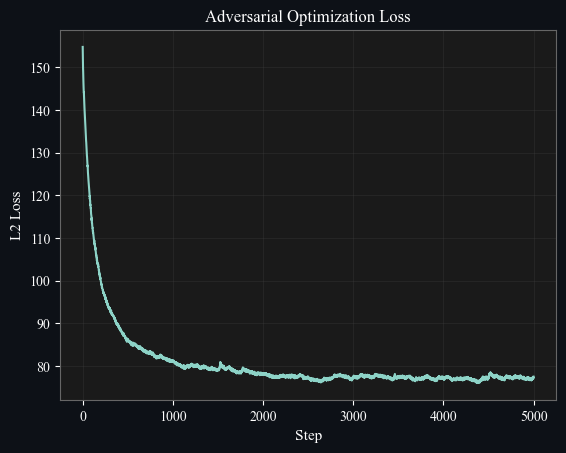

In [14]:
import os
import torch
from audioldm.utils import save_wave
import matplotlib.pyplot as plt

def get_mel(path1, device="cuda"):
    duration = 5
    fn_STFT = TacotronSTFT(
        filter_length=1024,
        hop_length=160,
        win_length=1024,
        n_mel_channels=64,
        sampling_rate=16000,
        mel_fmin=0,
        mel_fmax=8000,
    )
    mel1, _, _ = wav_to_fbank(
        path1, target_length=int(duration * 102.4), fn_STFT=fn_STFT
    )
    mel1 = mel1.unsqueeze(0).unsqueeze(0).to(device)
    mel1 = repeat(mel1, "1 ... -> b ...", b=1)
    return mel1

mel_orig, mel_transferred = get_mel(original), get_mel(transferred)
mel_adv = mel_orig.clone().detach().requires_grad_(True)
optimizer = torch.optim.Adam([mel_adv], lr=1e-2)
eps = 0.5
max_steps = 5_000
stagnation_window = 200
stagnation_threshold = 1e-5

loss_history = []

for step in range(max_steps):
    optimizer.zero_grad()
    z_adv = get_latent(mel_adv, latent_diffusion)
    z_target = get_latent(mel_transferred, latent_diffusion)
    loss = torch.norm(z_target - z_adv, p=2)
    loss.backward()
    optimizer.step()

    # clip perturbation
    delta = mel_adv - mel_orig
    delta = torch.clamp(delta, min=-eps, max=eps)
    mel_adv.data = mel_orig + delta

    loss_history.append(loss.item())
    print(f"Step {step+1}: Loss = {loss.item():.6f}")

    # automatic stopping
    if step > stagnation_window:
        recent = loss_history[-stagnation_window:]
        if max(recent) - min(recent) < stagnation_threshold:
            print(f"Stopping early at step {step+1}, loss stagnated")
            break

# decode adversarial audio
x_adv = latent_diffusion.decode_first_stage(get_latent(mel_adv, latent_diffusion))
waveform = latent_diffusion.first_stage_model.decode_to_waveform(x_adv)
waveform = waveform[:, None, :]
save_path = "./output"
os.makedirs(save_path, exist_ok=True)
save_wave(waveform, save_path, name="adversarial")

# plot loss curve
plt.plot(loss_history)
plt.xlabel("Step")
plt.ylabel("L2 Loss")
plt.title("Adversarial Optimization Loss")
plt.show()


Generate a control because audio quality gets reduced when generating same sample anyway.

In [17]:
# Encode and decode original mel through VAE
z_control = get_latent(mel_orig, latent_diffusion)  # just pass through
x_control = latent_diffusion.decode_first_stage(z_control)
waveform_control = latent_diffusion.first_stage_model.decode_to_waveform(x_control)
waveform_control = waveform_control[:, None, :]

save_wave(waveform_control, save_path, name="control")


Save audio to ./output\control_0.wav


In [18]:
# dist, sim, = latent_dist("vocal_sample.wav", "output/control_0.wav", latent_diffusion, device)
# print("L2 distance vocal to control:", dist, "cos similarity:", sim)
dist, sim, = latent_dist("output/control_0.wav", "output/control_0.wav", latent_diffusion, device)
print("Control to Control, L2:", dist, "Sim:", sim)
dist, sim = latent_dist("output/control_0.wav", "output/transfer/vocal_sample/24_08_2025_14_17_53_waterfall_0.wav", latent_diffusion, device)
print("Control to Transfer, L2:", dist, "Sim:", sim)
dist, sim = latent_dist("output/control_0.wav", "output/adversarial_0.wav", latent_diffusion, device)
print("Control to Adversarial, L2:", dist, "Sim:", sim)
dist, sim = latent_dist("output/adversarial_0.wav","output/transfer/vocal_sample/24_08_2025_14_17_53_waterfall_0.wav", latent_diffusion, device)
print("Adversarial to Transfer, L2:", dist, "Sim:", sim)

Control to Control, L2: 0.0015911087393760681 Sim: 0.9850557446479797
Control to Transfer, L2: 0.009496575221419334 Sim: 0.4025164246559143
Control to Adversarial, L2: 0.00754519272595644 Sim: 0.6266888380050659
Adversarial to Transfer, L2: 0.006706924643367529 Sim: 0.6573021411895752


In [20]:
!pip install --upgrade numba

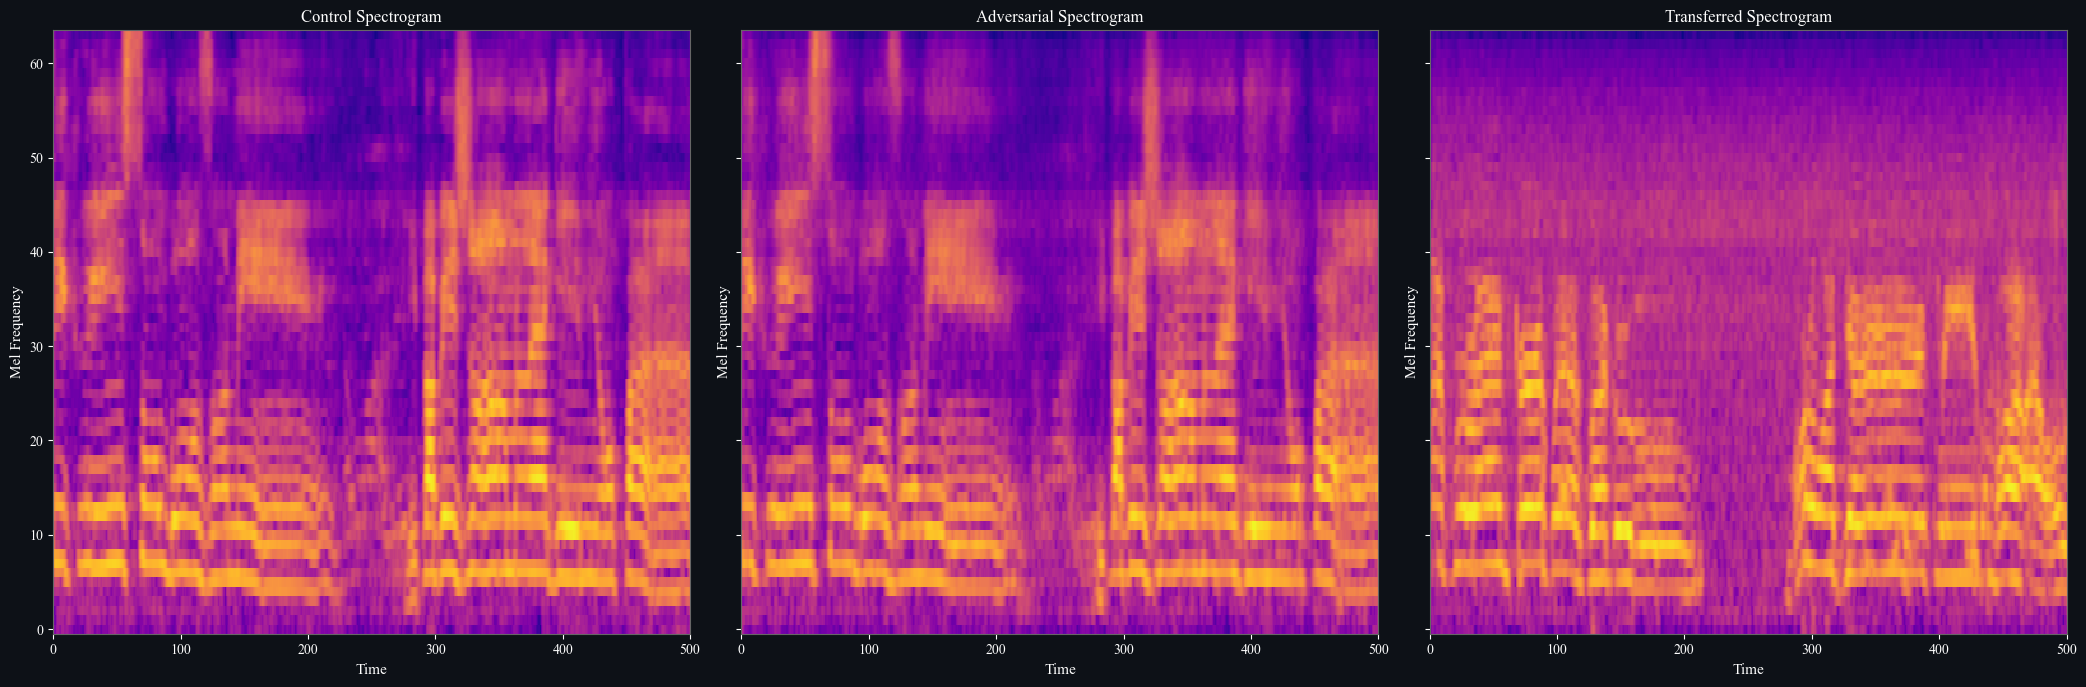

In [32]:
import torch
import torchaudio
import numpy as np
import matplotlib.pyplot as plt
from audioldm.audio.stft import TacotronSTFT
from audioldm.audio.tools import wav_to_fbank

# Define file paths
control_path = "output/control_0.wav"
adversarial_path = "output/adversarial_0.wav"
transfer_path = transferred  # This variable is defined in an earlier cell

# Function to load audio and plot its mel spectrogram using torchaudio
def plot_mel_spectrogram(path, ax, title, sr=16000):
    """Loads an audio file, computes its mel spectrogram, and plots it."""
    try:
        # Use torchaudio to compute mel spectrogram directly
        waveform, sample_rate = torchaudio.load(path)
        if sample_rate != sr:
            waveform = torchaudio.functional.resample(waveform, sample_rate, sr)
        
        # Convert to mono if stereo
        if waveform.shape[0] > 1:
            waveform = waveform.mean(dim=0, keepdim=True)
        
        # Compute mel spectrogram using torchaudio
        mel_transform = torchaudio.transforms.MelSpectrogram(
            sample_rate=sr,
            n_fft=1024,
            hop_length=160,
            win_length=1024,
            n_mels=64,
            f_min=0,
            f_max=8000
        )
        
        mel_spec = mel_transform(waveform)
        mel_spec_db = torchaudio.transforms.AmplitudeToDB()(mel_spec)
        
        # Limit to first 500 time frames
        mel_spec_db = mel_spec_db[:, :, :500]
        
        # Plot
        img = ax.imshow(
            mel_spec_db.squeeze().numpy(),
            aspect='auto',
            origin='lower',
            interpolation='nearest',
            cmap='plasma'  # Normal colormap
        )
        
        ax.set_xlabel('Time')
        ax.set_ylabel('Mel Frequency')
        ax.set_title(title)
        ax.grid(False)  # Remove grid
        ax.set_xlim(0, 500)  # Limit x-axis to 500
        
    except FileNotFoundError:
        ax.set_title(f"{title}\n(File not found)")
        ax.text(0.5, 0.5, 'Audio file not found', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        ax.grid(False)
    except Exception as e:
        ax.set_title(f"{title}\n(Error)")
        print(f"Could not process {path}: {e}")
        ax.grid(False)

# Create a figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(21, 7), sharey=True)

# Turn off grid for the figure
plt.rcParams['axes.grid'] = False

# Plot the spectrograms
plot_mel_spectrogram(control_path, axes[0], 'Control Spectrogram')
plot_mel_spectrogram(adversarial_path, axes[1], 'Adversarial Spectrogram')
plot_mel_spectrogram(transfer_path, axes[2], 'Transferred Spectrogram')

plt.tight_layout()
plt.show()

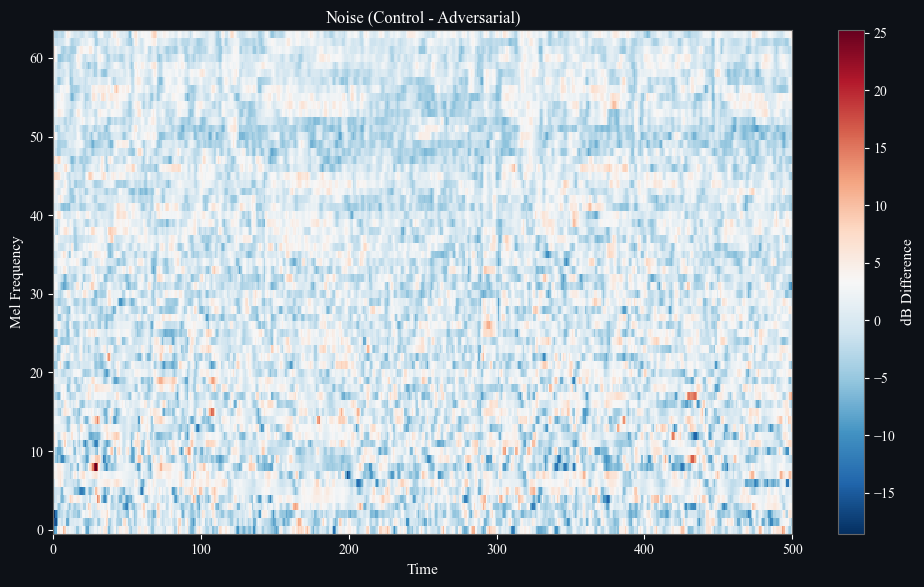

Noise spectrogram shape: (64, 500)
Noise range: [-18.54, 25.21] dB


In [39]:
# Function to compute noise (difference) between two audio files
def compute_noise_spectrogram(path1, path2, sr=16000):
    """Computes the difference spectrogram between two audio files."""
    try:
        # Load both audio files
        waveform1, sr1 = torchaudio.load(path1)
        waveform2, sr2 = torchaudio.load(path2)
        
        # Resample if needed
        if sr1 != sr:
            waveform1 = torchaudio.functional.resample(waveform1, sr1, sr)
        if sr2 != sr:
            waveform2 = torchaudio.functional.resample(waveform2, sr2, sr)
        
        # Convert to mono if stereo
        if waveform1.shape[0] > 1:
            waveform1 = waveform1.mean(dim=0, keepdim=True)
        if waveform2.shape[0] > 1:
            waveform2 = waveform2.mean(dim=0, keepdim=True)
        
        # Compute mel spectrograms
        mel_transform = torchaudio.transforms.MelSpectrogram(
            sample_rate=sr,
            n_fft=1024,
            hop_length=160,
            win_length=1024,
            n_mels=64,
            f_min=0,
            f_max=8000
        )
        
        mel_spec1 = mel_transform(waveform1)
        mel_spec2 = mel_transform(waveform2)
        
        mel_spec_db1 = torchaudio.transforms.AmplitudeToDB()(mel_spec1)
        mel_spec_db2 = torchaudio.transforms.AmplitudeToDB()(mel_spec2)
        
        # Match dimensions
        min_time = min(mel_spec_db1.shape[-1], mel_spec_db2.shape[-1])
        mel_spec_db1 = mel_spec_db1[:, :, :min_time]
        mel_spec_db2 = mel_spec_db2[:, :, :min_time]
        
        # Limit to first 500 time frames
        mel_spec_db1 = mel_spec_db1[:, :, :500]
        mel_spec_db2 = mel_spec_db2[:, :, :500]
        
        # Calculate noise (difference)
        noise = mel_spec_db1 - mel_spec_db2
        
        return noise.squeeze().numpy()
        
    except Exception as e:
        print(f"Error computing noise between {path1} and {path2}: {e}")
        return None

# Compute noise (Control - Adversarial)
noise_spectrogram = compute_noise_spectrogram(control_path, adversarial_path)

# Plot the noise spectrogram
if noise_spectrogram is not None:
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    
    img = ax.imshow(
        noise_spectrogram,
        aspect='auto',
        origin='lower',
        interpolation='nearest',
        cmap='RdBu_r'  # Red-Blue colormap for differences
    )
    
    ax.set_xlabel('Time')
    ax.set_ylabel('Mel Frequency')
    ax.set_title('Noise (Control - Adversarial)')
    ax.grid(False)
    ax.set_xlim(0, 500)
    
    plt.colorbar(img, ax=ax, label='dB Difference')
    plt.tight_layout()
    plt.show()
    
    print(f"Noise spectrogram shape: {noise_spectrogram.shape}")
    print(f"Noise range: [{noise_spectrogram.min():.2f}, {noise_spectrogram.max():.2f}] dB")
else:
    print("Failed to compute noise spectrogram")

Generate t-SNE mapping


In [1]:
import os
import torch
import numpy as np
import json
from pathlib import Path
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import warnings
from tqdm.notebook import tqdm
from einops import repeat
from audioldm.audio.stft import TacotronSTFT
from audioldm.audio.tools import get_mel_from_wav, wav_to_fbank
from audioldm.variational_autoencoder.distributions import DiagonalGaussianDistribution
from audioldm.pipeline import build_model

warnings.filterwarnings('ignore')

def find_audio_files(audio_path, extensions=('.mp3', '.wav', '.flac', '.m4a')):
    """Find all audio files in the given path"""
    audio_files = []
    audio_path = Path(audio_path)
    
    if audio_path.is_file():
        if audio_path.suffix.lower() in extensions:
            audio_files.append(audio_path)
    else:
        for ext in extensions:
            audio_files.extend(list(audio_path.rglob(f'*{ext}')))
    
    return sorted(audio_files)

def extract_latent_from_audio(audio_path, latent_diffusion, device="cuda"):
    """Extract latent representation from a single audio file"""
    try:
        # Preprocess audio to mel spectrogram
        mel = preprocess_audio(audio_path, device)
        
        # Get latent representation
        latent = get_latent(mel, latent_diffusion)
        
        # Flatten and return as numpy array
        return latent.flatten().cpu().numpy()
    except Exception as e:
        print(f"Error processing {audio_path}: {e}")
        return None

# Load AudioLDM model
print("Loading AudioLDM model...")
latent_diffusion = build_model(model_name="audioldm-m-full") 
latent_diffusion = latent_diffusion.to("cuda")
latent_diffusion.eval()



Loading AudioLDM model...
Load AudioLDM: %s audioldm-m-full
DiffusionWrapper has 415.95 M params.


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


LatentDiffusion(
  (model): DiffusionWrapper(
    (diffusion_model): UNetModel(
      (time_embed): Sequential(
        (0): Linear(in_features=192, out_features=768, bias=True)
        (1): SiLU()
        (2): Linear(in_features=768, out_features=768, bias=True)
      )
      (film_emb): Linear(in_features=512, out_features=768, bias=True)
      (input_blocks): ModuleList(
        (0): TimestepEmbedSequential(
          (0): Conv2d(8, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (1-2): 2 x TimestepEmbedSequential(
          (0): ResBlock(
            (in_layers): Sequential(
              (0): GroupNorm32(32, 192, eps=1e-05, affine=True)
              (1): SiLU()
              (2): Conv2d(192, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            )
            (h_upd): Identity()
            (x_upd): Identity()
            (emb_layers): Sequential(
              (0): SiLU()
              (1): Linear(in_features=1536, out_features=192, bias=Tr

In [7]:
# Set audio directory path (use raw string or forward slashes)
audio_directory = r"C:\Users\KGame\Documents\GitHub\DeepSound\AudioLDM\output\transfer\sample_1"

# Find all audio files
print(f"Searching for audio files in: {audio_directory}")
audio_files = find_audio_files(audio_directory)
print(f"Found {len(audio_files)} audio files")

if len(audio_files) == 0:
    print("No audio files found! Please check the path.")
else:
    # Extract latent representations
    print("Extracting latent representations...")
    latents = []
    file_names = []
    
    for audio_file in tqdm(audio_files, desc="Processing audio files"):
        latent = extract_latent_from_audio(audio_file, latent_diffusion)
        if latent is not None:
            latents.append(latent)
            file_names.append(audio_file.name)
    
    print(f"Successfully extracted {len(latents)} latent representations")
    
    if len(latents) > 0:
        # Convert to numpy array
        latents_array = np.array(latents)
        print(f"Latent array shape: {latents_array.shape}")
        
        # Save latent codes for later use
        np.save("latent_codes.npy", latents_array)
        with open("file_names.txt", "w") as f:
            for name in file_names:
                f.write(f"{name}\n")
        
        print("Saved latent codes to 'latent_codes.npy'")
        print("Saved file names to 'file_names.txt'")
        
        # Display first few results
        print("\nFirst 5 files and their latent dimensions:")
        for i in range(min(5, len(file_names))):
            print(f"{file_names[i]}: {latents_array[i].shape}")

Searching for audio files in: C:\Users\KGame\Documents\GitHub\DeepSound\AudioLDM\output\transfer\sample_1
Found 61 audio files
Extracting latent representations...


Processing audio files:   0%|          | 0/61 [00:00<?, ?it/s]

Successfully extracted 61 latent representations
Latent array shape: (61, 32384)
Saved latent codes to 'latent_codes.npy'
Saved file names to 'file_names.txt'

First 5 files and their latent dimensions:
17_08_2025_15_17_38_Still water with multiple overlapping human voices, each voice independent, creating layered ambient texture._0.wav: (32384,)
17_08_2025_15_28_52_Still water with multiple overlapping human voices, each voice independent, creating layered ambient texture._0.wav: (32384,)
17_08_2025_15_29_26_Slow-flowing water containing extended vocal runs, single vowel sounds stretched across multiple pitches, wordless expression._0.wav: (32384,)
17_08_2025_15_29_56_Flexible-tempo water rhythm with human breathing patterns, natural pauses and flows, organic timing variations._0.wav: (32384,)
17_08_2025_15_30_30_Very quiet continuous water flow with whispered vocal elements, smooth unbroken sound, barely audible presence._0.wav: (32384,)


In [20]:
# Load the saved latent codes
try:
    latents_array = np.load("latent_codes.npy")
    with open("file_names.txt", "r") as f:
        file_names = [line.strip() for line in f.readlines()]
    
    print(f"Loaded {len(file_names)} latent representations")
    print(f"Latent array shape: {latents_array.shape}")
    
    # Use PCA to reduce dimensions first (much more memory efficient)
    print("Reducing dimensions with PCA...")
    from sklearn.decomposition import PCA
    
    # Reduce to 50 dimensions first (much more manageable)
    pca = PCA(n_components=61, random_state=42)
    latents_reduced = pca.fit_transform(latents_array)
    
    print(f"PCA reduced shape: {latents_reduced.shape}")
    print(f"Explained variance ratio: {pca.explained_variance_ratio_.sum():.3f}")
    
    # Save the reduced data
    np.save("latents_pca_reduced.npy", latents_reduced)
    print("Saved PCA-reduced latent codes to 'latents_pca_reduced.npy'")
    
    # Display first few results
    print("\nFirst 5 files and their reduced dimensions:")
    for i in range(min(5, len(file_names))):
        print(f"{file_names[i]}: {latents_reduced[i].shape}")
        
except FileNotFoundError:
    print("No saved latent codes found. Please run the latent extraction cell first.")

Loaded 61 latent representations
Latent array shape: (61, 32384)
Reducing dimensions with PCA...
PCA reduced shape: (61, 61)
Explained variance ratio: 1.000
Saved PCA-reduced latent codes to 'latents_pca_reduced.npy'

First 5 files and their reduced dimensions:
17_08_2025_15_17_38_Still water with multiple overlapping human voices, each voice independent, creating layered ambient texture._0.wav: (61,)
17_08_2025_15_28_52_Still water with multiple overlapping human voices, each voice independent, creating layered ambient texture._0.wav: (61,)
17_08_2025_15_29_26_Slow-flowing water containing extended vocal runs, single vowel sounds stretched across multiple pitches, wordless expression._0.wav: (61,)
17_08_2025_15_29_56_Flexible-tempo water rhythm with human breathing patterns, natural pauses and flows, organic timing variations._0.wav: (61,)
17_08_2025_15_30_30_Very quiet continuous water flow with whispered vocal elements, smooth unbroken sound, barely audible presence._0.wav: (61,)


In [7]:
# Load the PCA-reduced latent codes
try:
    latents_reduced = np.load("latents_pca_reduced.npy")
    with open("file_names.txt", "r") as f:
        file_names = [line.strip() for line in f.readlines()]
    
    print(f"Loaded {len(file_names)} PCA-reduced latent representations")
    print(f"Reduced array shape: {latents_reduced.shape}")
    
    # Normalize the latent representations
    print("Normalizing latent representations...")
    scaler = StandardScaler()
    latents_normalized = scaler.fit_transform(latents_reduced)
    
    # Apply t-SNE with memory-efficient settings
    print("Applying t-SNE dimensionality reduction...")
    tsne = TSNE(
        n_components=3, 
        random_state=42, 
        perplexity=min(15, len(latents_reduced)-1),  # Lower perplexity
        n_iter=1000,  # Fewer iterations
        method='barnes_hut'  # More memory efficient for larger datasets
    )
    
    tsne_coords = tsne.fit_transform(latents_normalized)
    
    print(f"t-SNE coordinates shape: {tsne_coords.shape}")
    print(f"Raw t-SNE coordinate ranges:")
    print(f"  X: [{tsne_coords[:, 0].min():.3f}, {tsne_coords[:, 0].max():.3f}]")
    print(f"  Y: [{tsne_coords[:, 1].min():.3f}, {tsne_coords[:, 1].max():.3f}]")
    print(f"  Z: [{tsne_coords[:, 2].min():.3f}, {tsne_coords[:, 2].max():.3f}]")
    
    # Normalize t-SNE coordinates to [-1, 1] range for Sonic Pi compatibility
    print("Normalizing t-SNE coordinates to [-1, 1] range...")
    tsne_normalized = np.zeros_like(tsne_coords)
    
    for dim in range(3):
        coord_min = tsne_coords[:, dim].min()
        coord_max = tsne_coords[:, dim].max()
        
        # Normalize to [-1, 1] range
        tsne_normalized[:, dim] = 2.0 * (tsne_coords[:, dim] - coord_min) / (coord_max - coord_min) - 1.0
    
    print(f"Normalized t-SNE coordinate ranges:")
    print(f"  X: [{tsne_normalized[:, 0].min():.3f}, {tsne_normalized[:, 0].max():.3f}]")
    print(f"  Y: [{tsne_normalized[:, 1].min():.3f}, {tsne_normalized[:, 1].max():.3f}]")
    print(f"  Z: [{tsne_normalized[:, 2].min():.3f}, {tsne_normalized[:, 2].max():.3f}]")
    
    # Create results dictionary with both raw and normalized coordinates
    results = {
        'file_names': file_names,
        'pca_reduced_latents': latents_reduced.tolist(),
        'tsne_coordinates': tsne_normalized.tolist(),  # Use normalized coordinates
        'tsne_coordinates_raw': tsne_coords.tolist(),   # Keep raw for reference
        'metadata': {
            'num_files': len(file_names),
            'original_latent_dim': 32384,
            'pca_reduced_dim': latents_reduced.shape[1],
            'tsne_perplexity': tsne.perplexity,
            'tsne_random_state': tsne.random_state,
            'tsne_method': tsne.method,
            'coordinates_normalized': True,
            'normalization_range': [-1, 1]
        }
    }
    
    # Save results
    output_file = "latent_tsne_results.json"
    with open(output_file, 'w') as f:
        json.dump(results, f, indent=2)
    
    print(f"Results saved to: {output_file}")
    
    # Display first few results with normalized coordinates
    print("\nFirst 5 files and their normalized t-SNE coordinates:")
    for i in range(min(5, len(file_names))):
        coords = tsne_normalized[i]
        print(f"{file_names[i]}: [{coords[0]:.3f}, {coords[1]:.3f}, {coords[2]:.3f}]")
        
except FileNotFoundError:
    print("No PCA-reduced latent codes found. Please run the PCA reduction cell first.")

Loaded 61 PCA-reduced latent representations
Reduced array shape: (61, 61)
Normalizing latent representations...
Applying t-SNE dimensionality reduction...
t-SNE coordinates shape: (61, 3)
Raw t-SNE coordinate ranges:
  X: [-83.242, 86.583]
  Y: [-86.524, 59.086]
  Z: [-79.308, 85.711]
Normalizing t-SNE coordinates to [-1, 1] range...
Normalized t-SNE coordinate ranges:
  X: [-1.000, 1.000]
  Y: [-1.000, 1.000]
  Z: [-1.000, 1.000]
Results saved to: latent_tsne_results.json

First 5 files and their normalized t-SNE coordinates:
17_08_2025_15_17_38_Still water with multiple overlapping human voices, each voice independent, creating layered ambient texture._0.wav: [-0.170, 0.539, -0.275]
17_08_2025_15_28_52_Still water with multiple overlapping human voices, each voice independent, creating layered ambient texture._0.wav: [0.948, -0.265, -0.182]
17_08_2025_15_29_26_Slow-flowing water containing extended vocal runs, single vowel sounds stretched across multiple pitches, wordless expressio

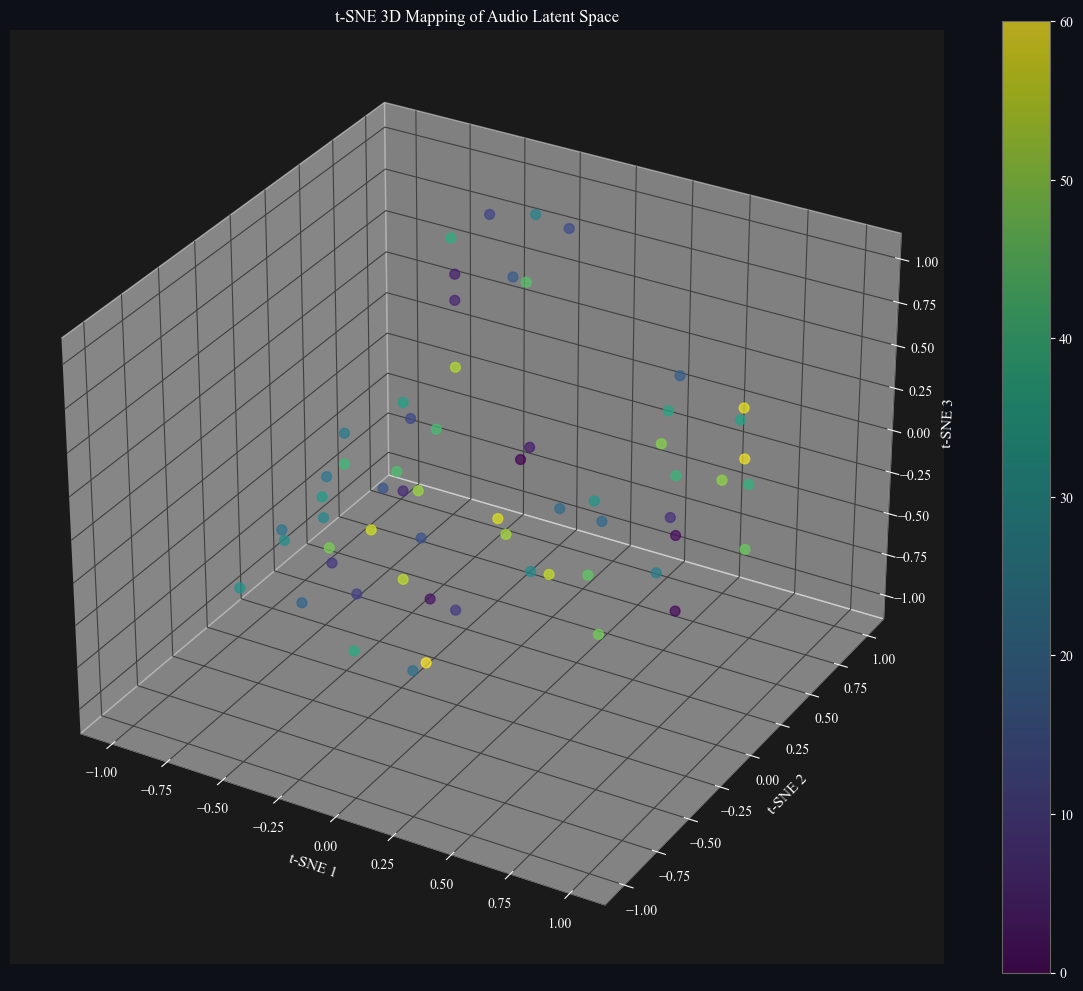

Visualized 61 audio samples in 3D space


In [8]:
# Optional: Create a simple 3D scatter plot
try:
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D
    
    # Load t-SNE coordinates
    with open("latent_tsne_results.json", "r") as f:
        results = json.load(f)
    
    tsne_coords = np.array(results['tsne_coordinates'])
    file_names = results['file_names']
    
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    scatter = ax.scatter(tsne_coords[:, 0], tsne_coords[:, 1], tsne_coords[:, 2], 
                       c=range(len(tsne_coords)), cmap='viridis', alpha=0.7, s=50)
    
    ax.set_xlabel('t-SNE 1')
    ax.set_ylabel('t-SNE 2')
    ax.set_zlabel('t-SNE 3')
    ax.set_title('t-SNE 3D Mapping of Audio Latent Space')
    
    plt.colorbar(scatter)
    plt.tight_layout()
    plt.show()
    
    print(f"Visualized {len(file_names)} audio samples in 3D space")
    
except ImportError:
    print("Matplotlib not available for 3D visualization")
except FileNotFoundError:
    print("No t-SNE results found. Please run the previous cells first.")